# 3. Modelo ML para el sistema de recomendación.

Basamos el sistema de recomendacion en un modelo no-supervisado. En este modelo, estimamos la semejanza de caracteristicas de los casos usando la similitud del coseno con base en información cualitativa (texto). Para afrontar las limitaciones de computo locales (intel duo + 8GB RAM) al procesar el tamaño de la informacion cualitativa (35.000+ casos), se clusterizaron los casos con base en una mezcla de variables quantiativas y categoricas. Por tal motivo, implementamos nuestro modelo en dos etapas. En la primera etapa, adoptamos una estrategia de clusterizacion de "arriba-abajo" para definir dos niveles de clusters con base en conocimiento previo. En la segunda etapa, estimamos la semejanza de caracteristicas de los casos mediante la similitud del coseno pero unicamente entre los casos miembros del cluster más bajo (nivel 2). De esta manera, logramos alivianar el procesamiento de datos al disminuir el tamaño de los datos con base en el cual se estima la similitud del coseno.

In [16]:
# librerias para manejo de datos
import psutil
import platform
import os
import glob
import numpy as np
import pandas as pd

# librerias para Kmeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

# librerias para calcular la similitud de cosenos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# otros
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Las caracteristicas de nuestra infrastructura local,
# lo cual pone limitaciones al momento de diseñar e implementar nuestro modelo.
print(platform.platform())
print("RAM:",str(round(psutil.virtual_memory().total / (1024.0 **3))),"GB")


macOS-10.15.7-x86_64-i386-64bit
RAM: 8 GB


In [18]:
# carga de datos
# quitamos lo valores nulos en 'overview'
data_mvp_ml = pd.read_csv(os.path.join('3_output','data_mvp_final_ml.csv'),index_col=0).convert_dtypes().dropna() 
print("Universo de peliculas unicas:",data_mvp_ml['pelicula_id'].nunique(),"\n")

data_mvp_ml.info()
data_mvp_ml.isna().sum()

Universo de peliculas unicas: 35834 

<class 'pandas.core.frame.DataFrame'>
Index: 42054 entries, 0 to 93359
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   original_language     42054 non-null  string 
 1   title                 42054 non-null  string 
 2   release_year          42054 non-null  Int64  
 3   pelicula_id           42054 non-null  Int64  
 4   genres                42054 non-null  string 
 5   prtgnst_nivel         42054 non-null  Int64  
 6   vote_average          42054 non-null  Float64
 7   prtgnst_gender_strng  42054 non-null  string 
 8   popularity            42054 non-null  Float64
 9   overview              42054 non-null  string 
dtypes: Float64(2), Int64(3), string(5)
memory usage: 3.7 MB


original_language       0
title                   0
release_year            0
pelicula_id             0
genres                  0
prtgnst_nivel           0
vote_average            0
prtgnst_gender_strng    0
popularity              0
overview                0
dtype: int64

## 3.1. Clusterizacion de los casos

En esta etapa definimos los clusters. Como mencionamos anteriormente, adoptamos un estrategia de "arriba-abajo" (tambien conocida como [Divisive Clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)). Empezamos con un primer nivel de clusterizacion y luego empleamos un segundo nivel de clusterizacion al interior del primero. En otras palabras, primero agrupamos los casos segun una serie variables "A" que consideramos de mayor importancia, y segundo identificamos subgrupos segun otras variables "B" que consideramos de menor importancia relativo a las variables "A". De esta manera, los clusters "A" adquieren un nivel mas alto de jerarquia sobre los cluster "B".


**Suposiciones en la identificacion de grupos:**

Para el primer nivel de clusters, identificamos grupos segun `popularity` y `release_year`. Nuestra intuicion es que el caso mas representativo de una audiencia son personas que prefieren ver peliculas populares (`popularity`) de una misma epoca (`release_year`); es decir, consideramos que estos son los dos criterios mas importante al momemento de elegir una pelicula.

Para el segundo nivel, agrupamos casos segun `genres`, `vote_average` y `prtgnst_gender_strng`. Para identificar estos grupos, suponemos que las personas prefieren elegir peliculas (al interior del grupo epoca-popularidad) segun el genero (`genres`) (p. ej., accion, drama, etc) y segun su calidad dada por el puntaje de los criticos y audiencia (`vote_average`). Tambien consideramos que las personas estan interesadas en peliculas si la protagonista es mujer (`prtgnst_gender_strng`).


**Virtud de nuestra estrategia:**

Consideramos que la mayor virtud de nuestra estrategia consiste en alivianar la carga computacional local al momento de calcular la similitud de cosenos.


**Limitaciones:**

Claramente, nuestras suposiciones sobre las preferencias de la audiencia no estan excentas de ser objeto de discusion. Por ejemplo, las personas pueden elegir una pelicula segun su genero (i.e., accion, drama, animada) independiente de la epoca en que fue producida; de igual manera, otras personas pueden privilegiar el actor principal o la casa productora al momento de elegir una pelicula. Pero consideramos que nuestras suposiciones constituyen un punto de partida que puede irse mejorando con la ayuda de mas datos y/o de literatura sobre las preferencias de la audiencia al momeneto de elegir peliculas.


**Pre-procesamiento: Transformaciones**

Previo al proceso de cluterizacion, escalamos todas las variables al rango 0,1. De esta manera, tanto las variables numericas como las categoricas transformadas en dummies (0,1) comparten un mismo rango. Esto garantiza que todas las variables tengan el mismo peso al momento de calcular las distancias de los centroides durante el proceso de clusterizacion.


In [19]:
# definimos nuestro la jerarquia de clusters.
vars_clstr_a=[
    'popularity',
    'release_year'
    ]
vars_clstr_b=[
    'genres',
    'prtgnst_gender_strng',
    'vote_average'
    ]
#vars_clstr_c=[ # no fue necesario llegar a un tercer nivel de clusterizacion
    #'franquicia',
    #'director',
    #'executive_producer'
#    ]

### 3.1.1. Clusters: Primer nivel

In [20]:
# nos concentramos en el primer nivel de clusters
# seleccionamos unicamente las variables que nos importan
data_mvp_ml_clstr_a=data_mvp_ml[['pelicula_id']+vars_clstr_a].drop_duplicates()
print("Numero de peliculas unicas:",data_mvp_ml_clstr_a['pelicula_id'].nunique(),"\n")
data_mvp_ml_clstr_a.set_index('pelicula_id', inplace=True)
data_mvp_ml_clstr_a.info()
data_mvp_ml_clstr_a.head(3)

Numero de peliculas unicas: 35834 

<class 'pandas.core.frame.DataFrame'>
Index: 35834 entries, 862 to 227506
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   popularity    35834 non-null  Float64
 1   release_year  35834 non-null  Int64  
dtypes: Float64(1), Int64(1)
memory usage: 944.8 KB


,popularity,release_year
pelicula_id,,
862,21.946943,1995
8844,17.015539,1995
15602,11.7129,1995


In [21]:
# Escalamos las variables al rango 0,1
scaler = preprocessing.MinMaxScaler()
scaler.fit(data_mvp_ml_clstr_a)
data_mvp_ml_clstr_a_scaled=pd.DataFrame(
    scaler.transform(data_mvp_ml_clstr_a),
    index=data_mvp_ml_clstr_a.index).rename(columns={0: "popularity_scaled", 1: "release_year_scaled"})
data_mvp_ml_clstr_a_scaled.head()

,popularity_scaled,release_year_scaled
pelicula_id,,
862,0.040087,0.810606
8844,0.031079,0.810606
15602,0.021394,0.810606
31357,0.007049,0.810606
11862,0.015320,0.810606


In [22]:
# Identificamos el numero optimo de clusters.
# Tomamos como limite maximo el numero que generaria clusters con un promedio de 1000 registros c/u
k_clstr_a_max=int(data_mvp_ml_clstr_a_scaled.shape[0]/1000) # 35

# iniciamos el loop
# SSE corresponde a Suma de distancias al cuadrado; es el equivalente al "residual" en regresion lineal.
# Interpretacion de SEE: entre mas bajo, cada registro esta mas cerca al centro del cluster mas cercano
sse = [] 
random_state=42
#KMeans(n_clusters=2, random_state=42)
for k in range(1, k_clstr_a_max): # escogemos 36 para generar clusters con un promedio de 1000 registros c/u.
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(data_mvp_ml_clstr_a_scaled)
    sse.append(kmeans.inertia_) # este es nuestro SSE

# identificamos el numero optimo de clusters
kl_eval = KneeLocator(range(1, k_clstr_a_max), sse, curve="convex", direction="decreasing")

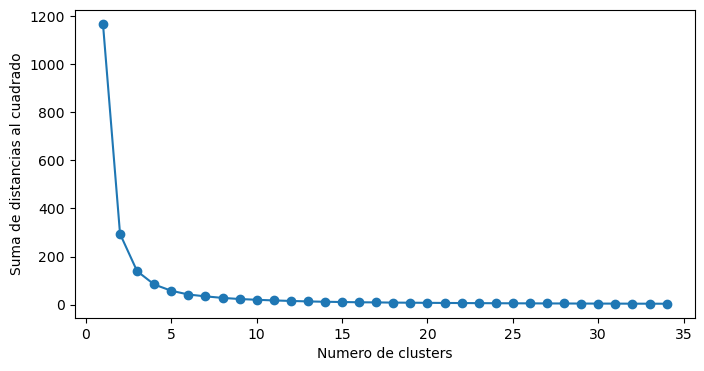

Numero optimo de clusters: 4


In [23]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, k_clstr_a_max), sse, marker='o')
plt.xlabel('Numero de clusters')
plt.ylabel('Suma de distancias al cuadrado')
plt.show()
k_optimo_clstr_a=kl_eval.elbow
print("Numero optimo de clusters:", k_optimo_clstr_a)

In [24]:
# clusterizamos los casos segun el numero optimo de clusters
# que identificamos en el paso anterior

# instanciamos
kmeans_clstr_a = KMeans(n_clusters=k_optimo_clstr_a, random_state=random_state)

# ajustamos
kmeans_clstr_a.fit(data_mvp_ml_clstr_a_scaled)

# asignamos membresia a cluster;
# sumamos 1 que el primer cluster no sea 0
data_mvp_ml_clstr_a_scaled['clstr_a'] = kmeans_clstr_a.predict(data_mvp_ml_clstr_a_scaled)+1 
data_mvp_ml_clstr_a_scaled.reset_index(inplace=True)
data_mvp_ml_clstr_a_scaled.info()
data_mvp_ml_clstr_a_scaled.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35834 entries, 0 to 35833
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pelicula_id          35834 non-null  Int64  
 1   popularity_scaled    35834 non-null  float64
 2   release_year_scaled  35834 non-null  float64
 3   clstr_a              35834 non-null  int32  
dtypes: Int64(1), float64(2), int32(1)
memory usage: 1015.0 KB


,pelicula_id,popularity_scaled,release_year_scaled,clstr_a
0,862,0.040087,0.810606,1
1,8844,0.031079,0.810606,1
2,15602,0.021394,0.810606,1
3,31357,0.007049,0.810606,1
4,11862,0.015320,0.810606,1


### 3.1.2. Clusters: Segundo nivel

In [25]:
# generamos dummies para la variable categorica genres
data_mvp_ml_dummies_genres = pd.get_dummies(
    data=data_mvp_ml[['pelicula_id','genres']].drop_duplicates().set_index('pelicula_id'),
    columns=['genres'], # genera dummies para cada grupo de valor por columna:
    drop_first=True, # elimina las variables reduntantes por columna
    dtype=float # dummies en valore numerico
    ).reset_index()

# Como nuestro objetivo es medir distnacia en un plano multi-dimensional, sintetizamos las dummies sobre un mismo eje (fila)
data_mvp_ml_dummies_genres = data_mvp_ml_dummies_genres.groupby('pelicula_id').sum().reset_index() 
print(data_mvp_ml_dummies_genres['pelicula_id'].nunique())
print(data_mvp_ml_dummies_genres.shape[0])
data_mvp_ml_dummies_genres.loc[data_mvp_ml_dummies_genres['pelicula_id']==862]


35834
35834


,pelicula_id,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,...,genres_Horror,genres_Music,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,genres_desconocido
678,862,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# generamos dummies para la variable categorica: genero de protagonista
data_mvp_ml_dummies_prtgnst = pd.get_dummies(
    data=data_mvp_ml[['pelicula_id','prtgnst_gender_strng']].drop_duplicates().set_index('pelicula_id'),
    columns=['prtgnst_gender_strng'], # genera dummies para cada grupo de valor por columna:
    drop_first=True, # elimina las variables reduntantes por columna
    dtype=float # dummies en valore numerico
    ).reset_index()
print(data_mvp_ml_dummies_prtgnst['pelicula_id'].nunique())
print(data_mvp_ml_dummies_prtgnst.shape[0])
data_mvp_ml_dummies_prtgnst.loc[data_mvp_ml_dummies_prtgnst['pelicula_id']==862]


35834
35834


,pelicula_id,prtgnst_gender_strng_mujer
0,862,0.0


In [27]:
# nos concentramos en la variable de interes
data_mvp_ml_clstr_b_vote = data_mvp_ml[['pelicula_id','vote_average']].drop_duplicates().set_index('pelicula_id')
data_mvp_ml_clstr_b_vote_array = data_mvp_ml_clstr_b_vote.to_numpy()
data_mvp_ml_clstr_b_vote.head(3)

,vote_average
pelicula_id,
862,7.7
8844,6.9
15602,6.5


In [28]:
# escalamos la variable de interes
scaler.fit(data_mvp_ml_clstr_b_vote_array)
data_mvp_ml_clstr_b_vote_scaled=pd.DataFrame(
    scaler.transform(data_mvp_ml_clstr_b_vote_array),
    index=data_mvp_ml_clstr_b_vote.index).rename(columns={0: 'vote_average_scaled'}).reset_index()
print(data_mvp_ml_clstr_b_vote_scaled['pelicula_id'].nunique())
print(data_mvp_ml_clstr_b_vote_scaled.shape[0])
data_mvp_ml_clstr_b_vote_scaled.head(3)

35834
35834


,pelicula_id,vote_average_scaled
0,862,0.77
1,8844,0.69
2,15602,0.65


In [29]:
data_mvp_ml_clstr_b=pd.merge(pd.merge(pd.merge(
    data_mvp_ml_clstr_b_vote_scaled,
    data_mvp_ml_dummies_genres,
    on='pelicula_id',
    how='left'),
    data_mvp_ml_dummies_prtgnst,
    on='pelicula_id'),
    data_mvp_ml_clstr_a_scaled[['pelicula_id','clstr_a']].drop_duplicates(), # anexamos la membresia al cluster A
    on='pelicula_id',
    how='left')#.set_index('pelicula_id')

# resultado
print(data_mvp_ml_clstr_b['pelicula_id'].nunique())
print(data_mvp_ml_clstr_b.shape[0])
data_mvp_ml_clstr_b=data_mvp_ml_clstr_b.set_index('pelicula_id')
data_mvp_ml_clstr_b.head(3)

35834
35834


,vote_average_scaled,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,genres_Foreign,...,genres_Mystery,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,genres_desconocido,prtgnst_gender_strng_mujer,clstr_a
pelicula_id,,,,,,,,,,,,,,,,,,,,,
862,0.77,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8844,0.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
15602,0.65,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [30]:
k_clstr_b_max=round(max(data_mvp_ml_clstr_b['clstr_a'].value_counts())/1000)
print(data_mvp_ml_clstr_b['clstr_a'].value_counts())
print("Numero max de clusters (promedio de 100 registros por subcluster):",k_clstr_b_max)

clstr_a
3    16801
1     8561
4     6509
2     3963
Name: count, dtype: int64
Numero max de clusters (promedio de 100 registros por subcluster): 17


In [31]:
# creamos un lista con los clusters unicos de la primera fase de clusterizacion
list_clstr_a=list(np.sort(data_mvp_ml_clstr_b['clstr_a'].unique()))
print(list_clstr_a)

[1, 2, 3, 4]


In [32]:
# en esta etapa, evaluamos el numero optimo
# de subclusters (nivel 2) para cada cluster (nivel 1)

# creamos un diccionario para ir colectando el numero optimo de subclusters para cada cluster
clstr_b_k_dict = {'clstr_a':[],'k_optimo':[]}

# iniciamo el loop para cada cluster nivel 1
for i in list_clstr_a:
    random_state=42
    #i=1
    data_mvp_ml_clstr_b_loop=data_mvp_ml_clstr_b.loc[data_mvp_ml_clstr_b['clstr_a']==i]

    sse = [] 
    for k in range(1, k_clstr_b_max):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(data_mvp_ml_clstr_b_loop)
        sse.append(kmeans.inertia_)

    # identificamos el numero optimo de subclusters (nivel 2)
    kl = KneeLocator(range(1, k_clstr_b_max), sse, curve="convex", direction="decreasing")
    k_optimo_clstr_b=kl.elbow
    clstr_b_k_dict['clstr_a'].append(i)
    clstr_b_k_dict['k_optimo'].append(k_optimo_clstr_b)

# generamos un dataframe con el numero optimo de cluster_b para cada cluster_a 
input_k_clstr_b = pd.DataFrame(data=clstr_b_k_dict)
input_k_clstr_b

,clstr_a,k_optimo
0,1,4
1,2,3
2,3,4
3,4,4


In [33]:
# creamos un df para recoger la asignacion de subclusters para cada caso (registro)
# usamos el index de pelicula_id para asignar los subclusters
data_mvp_ml_clstr_b_2concat = pd.DataFrame(
    {'col_2drop':[999 for i in range(data_mvp_ml_clstr_b.shape[0])]}, # variable basura para instancia un df vacio
    index=data_mvp_ml_clstr_b.index)

# iniciamos el loop para cada cluster nivel 1 para asignar sub clusters a cada pelicula 
for i in list_clstr_a:
    random_state=42
    #i=1
    data_mvp_ml_clstr_b_loop = data_mvp_ml_clstr_b.loc[data_mvp_ml_clstr_b['clstr_a']==i].drop(columns=['clstr_a'])
    k_optimo = int(input_k_clstr_b['k_optimo'].loc[input_k_clstr_b['clstr_a']==i])
    kmeans_clstr_b = KMeans(n_clusters=k_optimo, random_state=random_state)
    kmeans_clstr_b.fit(data_mvp_ml_clstr_b_loop)
    
    
    data_ml_clstr_b=pd.DataFrame(
        {'clstr_b':kmeans_clstr_b.predict(data_mvp_ml_clstr_b_loop)+1},
        index=data_mvp_ml_clstr_b_loop.index)
    data_ml_clstr_b['clstr_a']=i
    data_mvp_ml_clstr_b_2concat = pd.concat(
        [data_mvp_ml_clstr_b_2concat, data_ml_clstr_b], axis=0)
data_mvp_ml_clstr_b_label = data_mvp_ml_clstr_b_2concat.loc[
    data_mvp_ml_clstr_b_2concat['col_2drop']!=999].drop(columns=['col_2drop'])
print("Sub-cluster con el numero de registros mas alto:",max(data_mvp_ml_clstr_b_label[['clstr_a','clstr_b']].value_counts()))
data_mvp_ml_clstr_b_label.info()
data_mvp_ml_clstr_b_label.head(3)

Sub-cluster con el numero de registros mas alto: 11120
<class 'pandas.core.frame.DataFrame'>
Index: 35834 entries, 862 to 67179
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   clstr_b  35834 non-null  float64
 1   clstr_a  35834 non-null  float64
dtypes: float64(2)
memory usage: 874.9 KB


,clstr_b,clstr_a
pelicula_id,,
862,4.0,1.0
8844,2.0,1.0
15602,4.0,1.0


In [34]:
# universo de clusters y sub-clusters y su tamaño
print(data_mvp_ml_clstr_b_label.sort_values(
    by=['clstr_a','clstr_b']).groupby(['clstr_a','clstr_b']).value_counts())

# confirmamos que nuestra estrategia de asignacion de clusters
# ha sido consistente manteniendo el numero de registros en la base de datos
print("\nNumero de peliculas unicas:",data_mvp_ml_clstr_b_label.sort_values(
    by=['clstr_a','clstr_b']).groupby('clstr_a').value_counts().sum())

clstr_a  clstr_b
1.0      1.0         1583
         2.0         5728
         3.0          784
         4.0          466
2.0      1.0         2674
         2.0         1051
         3.0          238
3.0      1.0        11120
         2.0         3801
         3.0          913
         4.0          967
4.0      1.0          416
         2.0         4751
         3.0          241
         4.0         1101
Name: count, dtype: int64

Numero de peliculas unicas: 35834


# 3.2. Calculo de similitud de cosenos

In [35]:
# creamos un dataframe para estimar la similitud de cosenos
data_mvp_ml_cosine=pd.merge(
    data_mvp_ml[['pelicula_id','overview']].drop_duplicates(),
    data_mvp_ml_clstr_b_label.reset_index(),
    on='pelicula_id',
    how='left').dropna()
data_mvp_ml_cosine.info()
data_mvp_ml_cosine.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35834 entries, 0 to 35833
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pelicula_id  35834 non-null  Int64  
 1   overview     35834 non-null  string 
 2   clstr_b      35834 non-null  float64
 3   clstr_a      35834 non-null  float64
dtypes: Int64(1), float64(2), string(1)
memory usage: 1.1 MB


,pelicula_id,overview,clstr_b,clstr_a
0,862,"Led by Woody, Andy's toys live happily in his ...",4.0,1.0
1,8844,When siblings Judy and Peter discover an encha...,2.0,1.0
2,15602,A family wedding reignites the ancient feud be...,4.0,1.0
3,31357,"Cheated on, mistreated and stepped on, the wom...",1.0,1.0
4,11862,Just when George Banks has recovered from his ...,4.0,1.0


In [36]:
# previo a loop, removemos los archivos creados en instancias anteriors
list_files_remove = glob.glob(os.path.join('2_pipeline','data_mvp_ml_cosine_clstr_*.csv'))
removed=[os.remove(f) for f in list_files_remove]


In [37]:
# calculamos la similitud del coseno para cada cluster-subcluster
# hacemos esto mediante varios "for loop" anidados

# primero filtramos cada cluster (nivel 1)
for a in list(np.sort(data_mvp_ml_cosine['clstr_a'].unique())):
    data_mvp_ml_cosine_clstr_a=data_mvp_ml_cosine.loc[
        data_mvp_ml_cosine['clstr_a']==a].reset_index(drop=True)

    # segundo, filtramos cada sub-cluster (nivel 2)
    for b in list(np.sort(data_mvp_ml_cosine_clstr_a['clstr_b'].unique())):
        data_mvp_ml_cosine_clstr_a_clstr_b=data_mvp_ml_cosine_clstr_a.loc[
            data_mvp_ml_cosine_clstr_a['clstr_b']==b].reset_index(drop=True)

        # medimos la similitud de cosenos para cada pelicula
        # con respecto a todos los otros casos dentro del subcluster B
        # instanciamos
        tfidf = TfidfVectorizer()
        # ajustamos: creamos un matriz con vectores que sintentizan la relacion semantica entre palabras
        tfidf_matrix = tfidf.fit_transform(data_mvp_ml_cosine_clstr_a_clstr_b['overview'])
        # medimos la similitud de cosenos entre los vectores de la matriz
        matriz_simil = cosine_similarity(tfidf_matrix)

        # preparamos el loop para extraer los datos de la matriz:
        # para cada pelicula segun indice en el df y en la matriz tfidf_matrix
        list_cos_scores=list(data_mvp_ml_cosine_clstr_a_clstr_b.index)

        # instanciamos un df global con columna basura para ir agregando datos
        data_pelicula_cos_2concat = pd.DataFrame({'col_2drop':999},index=[0])
        #i=3
        
        # loop para extraer los datos de la matriz de similitudes de cosenos
        for i in list_cos_scores:
            # recogemos los datos en un diccionario
            pelicula_cos_dict = {}
            sim_scores = list(enumerate(matriz_simil[i]))
            sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
            pelicula_cos_dict.update(dict(sim_scores_sorted))
            
            # transformamos los datos del diccionario en un df
            data_pelicula_cos=pd.DataFrame.from_dict(
                data=pelicula_cos_dict,orient='index').reset_index().rename(
                    columns={'index': 'vecino', 0: 'cos_smltd'})
            data_pelicula_cos['index_p']=i # indice de la pelicula
            
            # agregamos los datos al df global
            data_pelicula_cos_2concat = pd.concat(
                [data_pelicula_cos_2concat, data_pelicula_cos],ignore_index=True)
        
        # quitamos la columna y filas basura del df global
        data_pelicula_cos_label = data_pelicula_cos_2concat.loc[
            data_pelicula_cos_2concat['col_2drop']!=999].drop(columns=['col_2drop']).drop_duplicates()
        
        # df con indices y etiqueta de membresia a clusters
        # para facilitar joins y mantener el id de casos
        data_mvp_ml_recomend_clstr_a_clstr_b = pd.merge(
            data_mvp_ml_cosine_clstr_a_clstr_b[['clstr_a','clstr_b','pelicula_id']],
            data_pelicula_cos_label.set_index('index_p'),
            left_index=True, right_index=True)
        
        # etiquetamos con id a cada vecino
        map_clstr_a_clstr_b=data_mvp_ml_recomend_clstr_a_clstr_b['pelicula_id'].reset_index().drop_duplicates()
        
        # generamos filas con valores basura para asigna pelicula_id (pk) a vecino_id
        data_mvp_ml_recomend_clstr_a_clstr_b['vecino_id']=99999 
        
        # al generar la matriz de similitudes de cosenos tfidf_matrix,
        # perdimos nuestro primary key asociado a cada pelicula
        # loop para asignar a cada vecino su pelicula_id (primary key)
        for v in list(np.sort(data_mvp_ml_recomend_clstr_a_clstr_b['vecino'].unique())):
            h = int(map_clstr_a_clstr_b['pelicula_id'].loc[map_clstr_a_clstr_b['index']==v])
            data_mvp_ml_recomend_clstr_a_clstr_b['vecino_id'].loc[data_mvp_ml_recomend_clstr_a_clstr_b['vecino']==v] = h
        data_mvp_ml_recomend_clstr_a_clstr_b.drop(columns=['vecino'],inplace=True)
        
        # guardamos el df para cada combinacion unica de cluster-subcluster
        # con el fin de alivianar la carga al RAM local:
        data_mvp_ml_recomend_clstr_a_clstr_b.to_csv(
            os.path.join("2_pipeline","data_mvp_ml_cosine_clstr_"+str(int(a))+"_clstr_"+str(int(b))+".csv"))

In [38]:
# cargamos todo los dfs generados en el paso anterior
# para cada combinacion unica de cluster-subcluster

list_files_mvp_ml_recomend = glob.glob(os.path.join('2_pipeline','data_mvp_ml_cosine_clstr_*.csv'))
list_files_mvp_ml_recomend.sort()
list_dfs_mvp_ml_recomend = [pd.read_csv(f,index_col=0) for f in list_files_mvp_ml_recomend]
data_mvp_ml_recomend = pd.concat(list_dfs_mvp_ml_recomend, ignore_index=True)

# asignamos titulo para cada pelicula
data_pel_titulo_2join=data_mvp_ml[['pelicula_id','title']].drop_duplicates()
data_mvp_ml_recomend=pd.merge(
    data_mvp_ml_recomend,
    data_pel_titulo_2join,
    on='pelicula_id',
    how='left')

# asignamos titulo para los vecinos de cada pelicula
data_vecino_titulo_2join=data_mvp_ml[['pelicula_id','title']].drop_duplicates().rename(
    columns={'pelicula_id': 'vecino_id', 'title': 'vecino_title'})
data_mvp_ml_recomend=pd.merge(
    data_mvp_ml_recomend,
    data_vecino_titulo_2join,
    on='vecino_id',
    how='left')
data_mvp_ml_recomend.info()
data_mvp_ml_recomend.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179170 entries, 0 to 179169
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   clstr_a       179170 non-null  float64
 1   clstr_b       179170 non-null  float64
 2   pelicula_id   179170 non-null  int64  
 3   cos_smltd     179170 non-null  float64
 4   vecino_id     179170 non-null  int64  
 5   title         179170 non-null  string 
 6   vecino_title  179170 non-null  string 
dtypes: float64(3), int64(2), string(2)
memory usage: 9.6 MB


,clstr_a,clstr_b,pelicula_id,cos_smltd,vecino_id,title,vecino_title
0,1.0,1.0,31357,0.133301,9400,Waiting to Exhale,Set It Off
1,1.0,1.0,31357,0.109291,9382,Waiting to Exhale,Boys on the Side
2,1.0,1.0,31357,0.104372,59871,Waiting to Exhale,Emmanuelle in the Country


In [39]:
# Ejemplo de consulta; recuerden que nuestro criterio de mayor jerarquia es la epoca+popularidad.
# Por tal motivo, nuestro resultados evidencian que al interior del cluster epoca+popularidad
# al que pertenece "Toy Story", la pelicula mas similar es "Toy Story 2" con un cos_smltd=0.400358.
# La siguiente pelicula mas similar es "Totally Fucked Up", aunque su cos_smltd=0.089975,
# lo cual es 70% mas bajo con respecto a "Toy Story 2".
# En otras palabras, nuestro sistema de recomendacion refleja que "Toy Story" fue tan unica y popular
# para su epoca, que tan solo existe una pelicula muy similar en su sub-cluster: "Toy Story 2".
data_mvp_ml_recomend.loc[data_mvp_ml_recomend['pelicula_id']==862]

,clstr_a,clstr_b,pelicula_id,cos_smltd,vecino_id,title,vecino_title
40475,1.0,4.0,862,0.404037,863,Toy Story,Toy Story 2
40476,1.0,4.0,862,0.089895,33560,Toy Story,Totally Fucked Up
40477,1.0,4.0,862,0.084557,11310,Toy Story,City Slickers II: The Legend of Curly's Gold
40478,1.0,4.0,862,0.082259,27850,Toy Story,Halloweentown
40479,1.0,4.0,862,0.073721,31609,Toy Story,Cheech & Chong Get Out of My Room


In [40]:
# exportamos el df para alimentar el sistema de recomendacion
data_mvp_ml_recomend_indexed=data_mvp_ml_recomend.set_index(['clstr_a','clstr_b'])
data_mvp_ml_recomend_indexed.drop_duplicates(inplace=True)
data_mvp_ml_recomend_indexed.to_csv(os.path.join("3_output","data_mvp_ml_recomend_indexed.csv"))